In [1]:
import sys
import os
import re

%matplotlib notebook
# %matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pylab as plt
import sys
import glob, os


curr_ld_lib_path = ''
os.environ['LD_LIBRARY_PATH'] = curr_ld_lib_path + ':/project/projectdirs/openmsi/jupyterhub_libs/boost_1_55_0/lib' + ':/project/projectdirs/openmsi/jupyterhub_libs/lib'
import sys
# sys.path.remove('/anaconda/lib/python2.7/site-packages')
sys.path.append('/global/project/projectdirs/openmsi/jupyterhub_libs/anaconda/lib/python2.7/site-packages')

sys.path.insert(0,'/global/project/projectdirs/metatlas/anaconda/lib/python2.7/site-packages' )

from metatlas import metatlas_objects as metob
from metatlas import h5_query as h5q
from metatlas import mzml_to_hdf


sys.path.append('/project/projectdirs/openmsi/projects/meta-iq/pactolus/pactolus')

import score_frag_dag

In [14]:
# import seaborn as sns
# %matplotlib notebook
# # %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
# from matplotlib import pylab as plt
# import sys
# sys.path.insert(0,'/global/project/projectdirs/metatlas/anaconda/lib/python2.7/site-packages' )
# from metatlas import metatlas_objects as metob
# from metatlas import h5_query as h5q
# from metatlas import mzml_to_hdf
# import glob, os


In [2]:
import tables

import numpy as np

In [3]:
my_run = metob.retrieve('lcmsrun', name='%20150910_C18_MeOH_NEG_MSMS_Scoelicolor_media_Ref_TwoNine_Day3_3of4___Run53%')
print my_run

[{'creation_time': '2015-09-20T03:35:03',
 'description': u'20150914_actinorhodin_finalset_50mm 20150910_C18_MeOH_NEG_MSMS_Scoelicolor_media_Ref_TwoNine_Day3_3of4___Run53.mzML',
 'hdf5_file': u'/project/projectdirs/metatlas/raw_data/kblouie/20150914_actinorhodin_finalset_50mm/20150910_C18_MeOH_NEG_MSMS_Scoelicolor_media_Ref_TwoNine_Day3_3of4___Run53.h5',
 'head_id': u'ac236419df994a32902c3cd37072d127',
 'last_modified': '2015-10-08T18:32:38',
 'method': None,
 'mzml_file': u'/project/projectdirs/metatlas/raw_data/kblouie/20150914_actinorhodin_finalset_50mm/20150910_C18_MeOH_NEG_MSMS_Scoelicolor_media_Ref_TwoNine_Day3_3of4___Run53.mzML',
 'name': u'20150910_C18_MeOH_NEG_MSMS_Scoelicolor_media_Ref_TwoNine_Day3_3of4___Run53.mzML',
 'prev_uid': u'origin',
 'sample': None,
 'unique_id': u'ac236419df994a32902c3cd37072d127',
 'username': u'kblouie'}]


In [4]:
with tables.open_file(my_run[0].hdf5_file) as fid:
    data = h5q.get_data(fid,2,0,min_rt = 5.1,max_rt = 7.9,min_precursor_MZ=633.12,max_precursor_MZ = 633.2)
print data['rt']

[ 7.5419445   7.5419445   7.5419445   7.5419445   7.5419445   7.5419445
  7.5419445   7.5419445   7.5419445   7.5419445   7.5419445   7.5419445
  7.5419445   7.5419445   7.5419445   7.5419445   7.5419445   7.5419445
  7.5419445   7.5419445   7.5419445   7.5419445   7.5419445   7.5419445
  7.5419445   7.5419445   7.5419445   7.5419445   7.5419445   7.5419445
  7.5419445   7.5419445   7.5419445   7.5419445   7.5419445   7.5419445
  7.5419445   7.5419445   7.5419445   7.5419445   7.5419445   7.5419445
  7.5419445   7.5419445   7.5419445   7.5419445   7.72450113  7.72450113
  7.72450113  7.72450113  7.72450113  7.72450113  7.72450113  7.72450113
  7.72450113  7.72450113  7.72450113  7.72450113  7.72450113  7.72450113
  7.72450113  7.72450113  7.72450113  7.72450113  7.72450113  7.72450113
  7.72450113  7.72450113  7.72450113  7.72450113  7.72450113  7.72450113
  7.72450113  7.72450113  7.72450113  7.72450113  7.72450113  7.72450113
  7.72450113]


In [5]:
def get_unique_scan_data(data):
    """
    Input:
    data - numpy nd array containing MSMS data
    
    Output:
    rt - retention time of scan
    pmz - precursor m/z of scan
    Both are sorted by descending precursor ion intensity
    
    for data returned from h5query.get_data(),
    return the retention time and precursor m/z
    sorted by descending precursor ion intensity
    """
    urt,idx = np.unique(data['rt'],return_index=True)
    idx
    sx = np.argsort(data['precursor_intensity'][idx])[::-1]
    prt = data['rt'][idx[sx]]
    pmz = data['precursor_MZ'][idx[sx]]
    return prt,pmz


def get_non_redundant_precursor_list(prt,pmz,rt_cutoff,mz_cutoff):
    """
    Input:
    rt - retention time of scan
    pmz - precursor m/z of scan
    Both are sorted by descending precursor ion intensity
    rt_cutoff - 
    mz_cutoff - 
    
    Output:
    list_of_prt - list of 
    list_of_pmz - list of 
    """
    
    list_of_pmz = [] #contains list of precursor m/z [pmz1,pmz2,...,pmz_n]
    list_of_prt = [] #contains list of precursor rt [prt1,prt2,...,prt_n]
    
    for i in range(len(prt)):
        if len(list_of_pmz) == 0:
            # none are in the list yet; so there is nothing to check
            list_of_pmz.append(pmz[i])
            list_of_prt.append(prt[i])
        else:
            # check if new rt qualifies for inclusion
            if min(abs(list_of_prt - prt[i])) > rt_cutoff or min(abs(list_of_pmz - pmz[i])) > mz_cutoff:
                list_of_pmz.append(pmz[i])
                list_of_prt.append(prt[i])
    return list_of_prt,list_of_pmz

In [6]:
prt,pmz = get_unique_scan_data(data)

rt_cutoff = 0.23
mz_cutoff = 0.05
list_of_prt,list_of_pmz = get_non_redundant_precursor_list(prt,pmz,rt_cutoff,mz_cutoff)


In [7]:
#setup data format for searching
pactolus_input = {}
pactolus_input['spectra'] = []
pactolus_input['precursor_mz'] = []
for i,(prt,pmz) in enumerate(zip(list_of_prt,list_of_pmz)):
    idx = np.argwhere((data['precursor_MZ'] == pmz) & (data['rt'] == prt )).flatten()
    arr = np.array([data['mz'][idx], data['i'][idx]]).T
    pactolus_input['spectra'].append(arr)
    pactolus_input['precursor_mz'].append(pmz)
    
pactolus_input

{'precursor_mz': [633.12708],
 'spectra': [array([[  6.02219849e+01,   5.13611426e+03],
         [  6.45197067e+01,   5.31844141e+03],
         [  6.98501816e+01,   5.67258447e+03],
         [  7.65564728e+01,   5.86723633e+03],
         [  1.02837791e+02,   6.63435449e+03],
         [  1.95310944e+02,   6.94508936e+03],
         [  1.95346817e+02,   5.35564795e+03],
         [  2.30951797e+02,   6.08355859e+03],
         [  2.58053192e+02,   1.16679834e+04],
         [  2.59062347e+02,   4.59729961e+04],
         [  2.73077271e+02,   7.24596094e+04],
         [  2.85077332e+02,   2.16664453e+04],
         [  3.07239838e+02,   5.24816797e+03],
         [  4.58103638e+02,   4.89963672e+04],
         [  4.60081451e+02,   3.66318633e+04],
         [  4.66106598e+02,   9.99861328e+03],
         [  4.67118042e+02,   7.16287158e+03],
         [  4.81088440e+02,   9.08090332e+03],
         [  4.83109131e+02,   1.46352406e+05],
         [  4.84119049e+02,   8.25898203e+04],
         [  4.85128

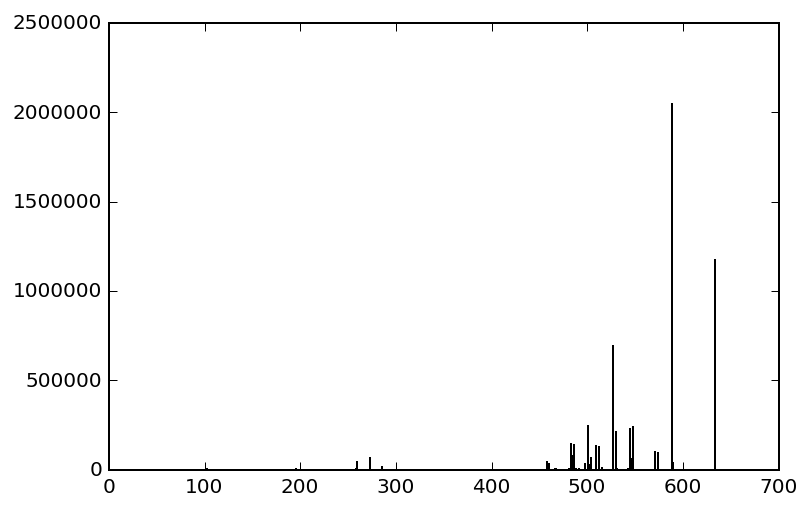

In [8]:
%matplotlib inline
plt.vlines(pactolus_input['spectra'][0][:,0],
           np.zeros(pactolus_input['spectra'][0][:,1].shape),
           pactolus_input['spectra'][0][:,1],
           color='k',linestyles='solid')
plt.show()

In [10]:
# # print data['precursor_MZ']
# # print data['rt']
# # data['mz']
# # data['i']
# # data['precursor_MZ']
# # idx = np.argsort(data['precursor_intensity'])[::-1]
# # data['precursor_intensity'][idx]
# # data['collision_energy']
print list_of_pmz
print list_of_prt
# print len(pmz)

[633.12671]
[7.6977539]


In [71]:
# print len(list_of_pmz_rt)
# print list_of_pmz_rt

In [72]:
# arr = np.array([data['mz'], data['i']]).T
# 
# other_arr = np.array([other_data['mz'], other_data['i']]).T

In [60]:
# all_my_h5_files = glob.glob('/project/projectdirs/openmsi/projects/pactolus_trees/*VTIKDEXOEJDMJP-WYUUTHIRSA-L*.h5')
for f in all_my_h5_files:
    if "VTIKDEXOEJDMJP" in f:
        print f



In [66]:
tree_table = np.load(maxdepth_5_table)
for t in tree_table:
    if abs(t[1] - 634.132255544) < 1:
        print t

('/project/projectdirs/openmsi/projects/pactolus_trees/FragTreeLibrary_test_hdf5_5_CCDRPBGPIXPGRW-UHFFFAOYSA-N.h5', 634.4080834360016)
('/project/projectdirs/openmsi/projects/pactolus_trees/FragTreeLibrary_test_hdf5_5_WJMMBVSOQPALFO-BHYGPSQDSA-N.h5', 634.4080834360016)
('/project/projectdirs/openmsi/projects/pactolus_trees/FragTreeLibrary_test_hdf5_5_NARQRJFIZNOSJV-UHFFFAOYSA-N.h5', 634.4080834360016)
('/project/projectdirs/openmsi/projects/pactolus_trees/FragTreeLibrary_test_hdf5_5_GJIGVPBRJFOUGD-SSQLMYNASA-N.h5', 634.4749812240018)
('/project/projectdirs/openmsi/projects/pactolus_trees/FragTreeLibrary_test_hdf5_5_HRUXIQZFNLQZQA-UHFFFAOYSA-N.h5', 635.0877176640005)


In [9]:
pos_mode_neutralizations = [-1.00727646677, -(1.00727646677+1.00782504), +5.4857990946e-4,]
neg_mode_neutralizations = [-el for el in pos_mode_neutralizations]

# make lookup table
# path_to_trees = '/project/projectdirs/openmsi/projects/pactolus_trees/'
# all_my_h5_files = glob.glob('/project/projectdirs/openmsi/projects/pactolus_trees/*_hdf5_5_*.h5')

path_to_trees = '/project/projectdirs/openmsi/projects/ben_trees/'
all_my_h5_files = glob.glob('/project/projectdirs/openmsi/projects/ben_trees/*_hdf5_5_*.h5')

my_tree_filename = 'metacyc_max_depth_5'

if not os.path.isfile(os.path.join(path_to_trees, my_tree_filename + '.npy')):
    score_frag_dag.make_file_lookup_table_by_MS1_mass(all_my_h5_files, 
                                                      path=path_to_trees, 
                                                      save_result='metacyc_max_depth_5')

maxdepth_5_table = os.path.join(path_to_trees, my_tree_filename + '.npy')

params = {'file_lookup_table': maxdepth_5_table,
          'ms1_mass_tol': 0.05,
          'ms2_mass_tol': 0.05,
          'neutralizations': neg_mode_neutralizations,
          'max_depth': 5,
              }

print neg_mode_neutralizations

IOError: [Errno 2] No such file or directory: '/global/homes/b/bpb/trees/gen_tree_result_neutralized_metacyc/metacyc_max_depth_5.npy'

In [49]:
pactolus_input

{'precursor_mz': [633.12708],
 'spectra': [array([[  6.02219849e+01,   5.13611426e+03],
         [  6.45197067e+01,   5.31844141e+03],
         [  6.98501816e+01,   5.67258447e+03],
         [  7.65564728e+01,   5.86723633e+03],
         [  1.02837791e+02,   6.63435449e+03],
         [  1.95310944e+02,   6.94508936e+03],
         [  1.95346817e+02,   5.35564795e+03],
         [  2.30951797e+02,   6.08355859e+03],
         [  2.58053192e+02,   1.16679834e+04],
         [  2.59062347e+02,   4.59729961e+04],
         [  2.73077271e+02,   7.24596094e+04],
         [  2.85077332e+02,   2.16664453e+04],
         [  3.07239838e+02,   5.24816797e+03],
         [  4.58103638e+02,   4.89963672e+04],
         [  4.60081451e+02,   3.66318633e+04],
         [  4.66106598e+02,   9.99861328e+03],
         [  4.67118042e+02,   7.16287158e+03],
         [  4.81088440e+02,   9.08090332e+03],
         [  4.83109131e+02,   1.46352406e+05],
         [  4.84119049e+02,   8.25898203e+04],
         [  4.85128

In [12]:
foo = score_frag_dag.score_scan_list_against_trees(pactolus_input['spectra'], pactolus_input['precursor_mz'], params)
np.argmax(foo)

0

In [33]:
my_db = '/project/projectdirs/openmsi/projects/meta-iq/pactolus/data/' + 'MetaCyc.mdb'
pactolus_results = score_frag_dag.make_pactolus_hit_table(foo, maxdepth_5_table, original_db=my_db)

In [37]:
for r in pactolus_results:
    if len(r)>0:
        print r[0]

(0.7875834703445435, 'MetaCyC_10461', 'ethyl red', 297.1477355957031, 0, 0)
(0.9809126853942871, 'MetaCyC_7413', 'emodin', 270.0528259277344, 0, 0)
(0.0572817325592041, 'MetaCyC_1181', '(1<i>S</i>,6<i>R</i>)-2-succinyl-6-hydroxy-2,4-cyclohexadiene-1-carboxylate', 240.06338500976562, 0, 0)
(0.23310670256614685, 'MetaCyC_1416', 'tetrachloroethene', 163.8754119873047, 0, 0)
(0.5957505702972412, 'MetaCyC_8529', 'levoglucosan', 162.05282592773438, 0, 0)
(0.0007101739174686372, 'MetaCyC_6396', '2-12:0-lysoPG', 428.217529296875, 0, 0)
(0.33812853693962097, 'MetaCyC_752', 'pentachloroethane', 199.85208129882812, 0, 0)
(0.7275602221488953, 'MetaCyC_9299', 'cortolone', 366.2406311035156, 0, 0)
(1.4161595106124878, 'MetaCyC_7168', '1D-<i>chiro</i>-inositol', 180.06338500976562, 0, 0)
(0.12381210178136826, 'MetaCyC_6694', "3-(2'-methylthio)ethylmalic-acid", 208.04054260253906, 0, 0)
(0.21038520336151123, 'MetaCyC_7088', '3-dehydroteasterone', 446.339599609375, 0, 0)
(0.8556255102157593, 'MetaCyC_7

In [50]:
233.15416+1.00727646677

234.16143646677

In [51]:
234.161979944-234.16143646677

0.0005434772299963697

In [68]:
foo = np.load(maxdepth_5_table)

In [69]:
foo

array([ ('/project/projectdirs/openmsi/projects/pactolus_trees/FragTreeLibrary_test_hdf5_5_OOXWYYGXTJLWHA-UHFFFAOYSA-N.h5', 40.031300128),
       ('/project/projectdirs/openmsi/projects/pactolus_trees/FragTreeLibrary_test_hdf5_5_XZMCDFZZKTWFGF-UHFFFAOYSA-N.h5', 42.021798063999995),
       ('/project/projectdirs/openmsi/projects/pactolus_trees/FragTreeLibrary_test_hdf5_5_QQONPFPTGQHPMA-UHFFFAOYSA-N.h5', 42.046950192),
       ...,
       ('/project/projectdirs/openmsi/projects/pactolus_trees/FragTreeLibrary_test_hdf5_5_NTXGVHCCXVHYCL-UHFFFAOYSA-N.h5', 926.6318285440028),
       ('/project/projectdirs/openmsi/projects/pactolus_trees/FragTreeLibrary_test_hdf5_5_HMTFXPJOBPIOIN-UHFFFAOYSA-N.h5', 952.7187878080008),
       ('/project/projectdirs/openmsi/projects/pactolus_trees/FragTreeLibrary_test_hdf5_5_RGHRJBIKIYUHEV-UHFFFAOYSA-N.h5', 952.7187878080008)], 
      dtype=[('filename', 'S400'), ('ms1_mass', '<f8')])